#**House Price Prediction**


In [ ]:
#testing GPU is enable
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

import time
import datetime

##Global functions and variables 

In [ ]:
FETCH_UPDATED = True

_folder_dir= '/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/'
_dataset = 'housing'
_dataset2 = 'housing_updated_bedrooms'
_full_dataset = 'housing_updated_full_features'

_ds_report = 'report'
_pickle = 'loc_update_3'



In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    perc = value/max*100
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
        <h1> {perc}% </h1>
    """.format(value=value, max=max,perc=perc))

##Fetch Dataset

In [ ]:
#fetch data set

#ds_dir = _folder_dir+_dataset+('_updated' if FETCH_UPDATED else '') + '.csv'
#df = pd.read_csv (r'/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/housing.csv') #use it for Initial Experiment
#df = pd.read_csv (r'/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/housing_updated_initial_features.csv') #use it for 2.4.1 Experiment 2
df = pd.read_csv (r'/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/housing_updated_full_features.csv') #use it for Experiment 3 and 4





###Dataset Status

In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,County,Road
0,-117.14,32.71,32.0,719.0,251.0,894.0,208.0,1.8456,103100.0,NEAR OCEAN,San Diego County,25th Street
1,-120.72,37.38,22.0,1311.0,319.0,1455.0,340.0,2.2813,67300.0,INLAND,Merced County,6th Street
2,-117.32,34.12,37.0,2868.0,574.0,2055.0,563.0,2.3508,70500.0,INLAND,San Bernardino County,West 11th Street
3,-118.27,33.91,42.0,1786.0,358.0,1318.0,373.0,2.6250,101100.0,<1H OCEAN,Los Angeles County,Jarvis Avenue
4,-118.48,34.20,23.0,2850.0,864.0,2249.0,777.0,2.6957,191700.0,<1H OCEAN,Los Angeles County,Enadia Way


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  County              20640 non-null  object 
 11  Road                20640 non-null  object 
dtypes: float64(9), object(3)
memory usage: 1.9+ MB


## Initial Data Analytics 

In [ ]:
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 4.7 MB/s 


In [ ]:
import sweetviz as sv

In [ ]:


report = sv.analyze(df)

report.show_html(_folder_dir + _ds_report + '.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##Remove Missng total_bedrooms entries

In [ ]:
total_bedrooms_miss_idx = []
for index, row in df[df['total_bedrooms'].isnull()].iterrows():
  total_bedrooms_miss_idx.append(index)

df= df.drop(total_bedrooms_miss_idx)


In [ ]:
total_bedrooms_miss_idx = []
for index, row in df[df['Road'].isnull()].iterrows():
  total_bedrooms_miss_idx.append(index)

df= df.drop(total_bedrooms_miss_idx)

In [ ]:
total_bedrooms_miss_idx = []
for index, row in df[df['County'].isnull()].iterrows():
  total_bedrooms_miss_idx.append(index)

df= df.drop(total_bedrooms_miss_idx)
total_bedrooms_miss_idx

[]

In [ ]:
df.shape[0]

20433

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19313 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19313 non-null  float64
 1   latitude            19313 non-null  float64
 2   housing_median_age  19313 non-null  float64
 3   total_rooms         19313 non-null  float64
 4   total_bedrooms      19313 non-null  float64
 5   population          19313 non-null  float64
 6   households          19313 non-null  float64
 7   median_income       19313 non-null  float64
 8   median_house_value  19313 non-null  float64
 9   ocean_proximity     19313 non-null  object 
 10  County              19313 non-null  object 
 11  Road                19313 non-null  object 
dtypes: float64(9), object(3)
memory usage: 2.5+ MB


**bold text**##Data Pre-Proccessing 




In [ ]:
from geopy.geocoders import Nominatim
import pickle

###Exmples

In [ ]:
## Feature Engineering


geolocator = Nominatim(user_agent = 'geoapiExercices')


In [ ]:
#geolocator example
geolocator.reverse("37.88"+","+ "-122.23")[0]
geolocator.reverse("37.88"+","+ "-122.23").raw['address']

{'city': 'Oakland',
 'country': 'United States',
 'country_code': 'us',
 'county': 'Alameda County',
 'leisure': 'Ecological Study Area',
 'postcode': '94720',
 'road': 'Grizzly Peak Boulevard',
 'state': 'California'}

### Generate a pickle file

In [ ]:
#get raw address given a latetude and longatude cord

loc_update = {
    "County":[],
    "Road":[]
}

def location(cord):
  long = str(cord[0])
  lat = str(cord[1])
  #print(cord)
  location = geolocator.reverse(lat + "," + long).raw['address'] # dictiomary
  # print(location)
  
  #replace the missing places
  if location.get('road') is None:
    location['road'] = None

  if location.get('county') is None:
    location['county'] = None

  #print(location["road"])
  loc_update['Road'].append(location['road'])

  loc_update['County'].append(location['county'])



In [ ]:
#print(df.iloc[:,0:2])
import time

start = time.time()

out = display(progress(0, df.shape[0]), display_id=True)


for i,cord in enumerate(df.iloc[:,0:2].values):
  location(cord)

  pickle.dump(loc_update,open('/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/loc_update_3.pickle','wb'))
  out.update(progress(i, df.shape[0]))

  # if i%100 == 5:
  #   print(str((i/df.shape[0])*100)+"%")
  #   break

stop = time.time()
print('Time: ', stop - start," Sec")  
print("Done")

NameError: ignored

In [ ]:
#the time that toked to get updated location (generate loc_update.pickle)
print(i)
import datetime
t_sec  = 10322.550931215286
str(datetime.timedelta(seconds=t_sec))


### Load a pickle file

In [ ]:
#load a pickle module
#loc_update2 = pickle.load(open(_folder_dir + _pickle + '.pickle' ,"rb"))

loc_update2 = pickle.load(open('/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/loc_update_3.pickle' ,"rb"))
# loc = pd.DataFrame(loc_update2)



In [ ]:
# add new features to dataframe
for feature in loc_update2.keys():
  df[feature] = loc_update2[feature]

df = df.sample(axis=0,frac=1) #to random


###Dataset Status

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19313 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_income       19313 non-null  float64
 1   median_house_value  19313 non-null  float64
 2   ocean_proximity     19313 non-null  object 
dtypes: float64(2), object(1)
memory usage: 1.2+ MB


In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,County,Road
6107,-117.90,34.11,37.0,1286.0,255.0,1047.0,249.0,4.2019,140100.0,<1H OCEAN,Los Angeles County,East Newburgh Street
12355,-116.54,33.80,22.0,6050.0,1387.0,1432.0,890.0,2.2216,183900.0,INLAND,Riverside County,East Twin Palms Drive
1053,-121.83,39.76,12.0,9831.0,1921.0,4644.0,1775.0,3.1142,112600.0,INLAND,Butte County,Floral Avenue
15673,-122.44,37.80,52.0,2865.0,593.0,1029.0,577.0,5.2539,500001.0,NEAR BAY,San Francisco,Chestnut Street
15868,-122.41,37.76,52.0,3452.0,784.0,2987.0,753.0,2.8135,260300.0,NEAR BAY,San Francisco,Bryant Street


##Using calssification algo to fill the missing values


In [ ]:
from sklearn.linear_model import SGDClassifier
import time,datetime

In [ ]:


def creat_in_dependent_features():
  global miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #independent features
  miss_X_train = np.array([[df['total_rooms'][i],df['households'][i],df['median_income'][i]] for i in range(df.shape[0])if i not in miss_idx])
  miss_y_train = np.array([df[_feature_][i] for i in range(df.shape[0])if i not in miss_idx])

  miss_X_test = np.array([[df['total_rooms'][i],df['households'][i],df['median_income'][i]] for i in range(df.shape[0])if i in miss_idx])

def init_feature_model():
  global SGD_model

  # init model 
  s = time.time()
  SGD_model = SGDClassifier() #(verbose=1)
  print("Feature '{}': Init model done. time={}".format(_feature_, str(datetime.timedelta(seconds=time.time()-s))))

def train_feature_mode():
  global SGD_model ,miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #model training
  s = time.time()
  SGD_model.fit(miss_X_train,miss_y_train)
  print("Feature '{}': Training done. time={}".format(_feature_, str(datetime.timedelta(seconds=time.time() -s ))))

def predict_feature_mode():
  global SGD_model ,miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #predict
  s = time.time()
  miss_y_pred = SGD_model.predict(miss_X_test)
  print("Feature '{}': Prediction done. time={}".format(_feature_, str(datetime.timedelta(seconds= time.time() -s))))

def update_feature_bak_to_dataframe():
  global SGD_model ,miss_X_train ,miss_y_train,miss_X_test, miss_y_pred

  #add the missing values back to dataframe
  for n,i in enumerate(miss_idx):
    df[_feature_][i] = miss_y_pred[n]

### Road feature

In [ ]:
#appling Logistic algo 

_feature_ = 'Road'
miss_idx = []
for i in range(df.shape[0]):
  if df[_feature_][i] is None:
    miss_idx.append(i)

creat_in_dependent_features()

init_feature_model()
train_feature_mode()
predict_feature_mode()

update_feature_bak_to_dataframe()


Feature 'Road': Init model done. time=0:00:00.000035
Feature 'Road': Training done. time=0:04:53.629013
Feature 'Road': Prediction done. time=0:00:00.087786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


###County

In [ ]:
#appling Logistic algo 
_feature_ = 'County'
miss_idx = []
for i in range(df.shape[0]):
  if df[_feature_][i] is None:
    miss_idx.append(i)

creat_in_dependent_features()

init_feature_model()
train_feature_mode()
predict_feature_mode()

update_feature_bak_to_dataframe()


Feature 'County': Init model done. time=0:00:00.000027
Feature 'County': Training done. time=0:00:03.706909
Feature 'County': Prediction done. time=0:00:00.003180


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


###total_bedrooms Feature

In [ ]:
#appling Logistic algo 
_feature_ = 'total_bedrooms'

miss_idx = []
for index, row in df[df[_feature_].isnull()].iterrows():
  miss_idx.append(index)


creat_in_dependent_features()

init_feature_model()
train_feature_mode()
predict_feature_mode()

update_feature_bak_to_dataframe()



Feature 'total_bedrooms': Init model done. time=0:00:00.000035
Feature 'total_bedrooms': Training done. time=0:01:27.398662
Feature 'total_bedrooms': Prediction done. time=0:00:00.005009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Dataframe Status

In [ ]:
# no data missing in our data set
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 14300 to 15434
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  County              20640 non-null  object 
 11  Road                20640 non-null  object 
dtypes: float64(9), object(3)
memory usage: 2.7+ MB


###Save data fram to updated .csv file



In [ ]:
_final_csv = _folder_dir + _dataset + '_updated_initial_features' + '.csv'
print(_final_csv)
df.to_csv(_final_csv,index=False)

df5 = pd.read_csv (_final_csv)
df5.head()


/content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/housing_updated_initial_features.csv


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,County,Road
0,-117.90,34.11,37.0,1286.0,255.0,1047.0,249.0,4.2019,140100.0,<1H OCEAN,Los Angeles County,East Newburgh Street
1,-116.54,33.80,22.0,6050.0,1387.0,1432.0,890.0,2.2216,183900.0,INLAND,Riverside County,East Twin Palms Drive
2,-121.83,39.76,12.0,9831.0,1921.0,4644.0,1775.0,3.1142,112600.0,INLAND,Butte County,Floral Avenue
3,-122.44,37.80,52.0,2865.0,593.0,1029.0,577.0,5.2539,500001.0,NEAR BAY,San Francisco,Chestnut Street
4,-122.41,37.76,52.0,3452.0,784.0,2987.0,753.0,2.8135,260300.0,NEAR BAY,San Francisco,Bryant Street


##Labels Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


In [ ]:
#encode label features 
# from sklearn.preprocessing import LabelEncoder

df['Road'] = le.fit_transform(df['Road'])

In [ ]:
#encode label features ocean_proximity

df['ocean_proximity'] = le.fit_transform(df['ocean_proximity'])

In [ ]:
df['County'] = le.fit_transform(df['County'])

In [ ]:
#the dataframe now have a categorical values
#not a string format (label encoding)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,County,Road
0,-117.14,32.71,32.0,719.0,251.0,894.0,208.0,1.8456,103100.0,4,39,62
1,-120.72,37.38,22.0,1311.0,319.0,1455.0,340.0,2.2813,67300.0,1,25,131
2,-117.32,34.12,37.0,2868.0,574.0,2055.0,563.0,2.3508,70500.0,1,38,8508
3,-118.27,33.91,42.0,1786.0,358.0,1318.0,373.0,2.6250,101100.0,0,20,3935
4,-118.48,34.20,23.0,2850.0,864.0,2249.0,777.0,2.6957,191700.0,0,20,2853


##Final Data analysis 

###Numerical columns data analysis

<Figure size 360x360 with 0 Axes>

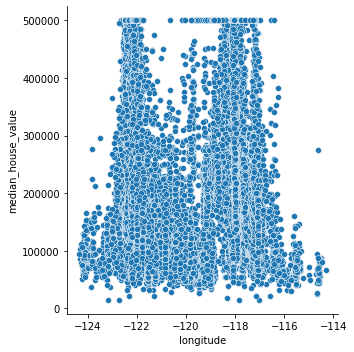

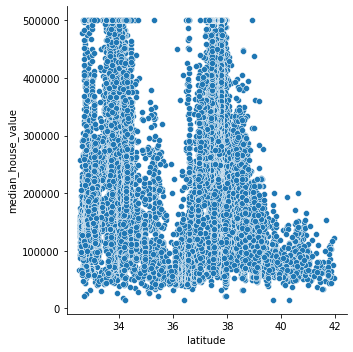

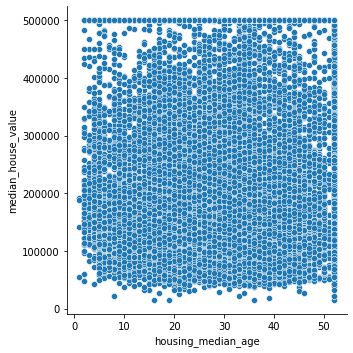

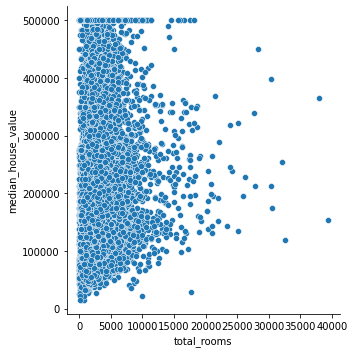

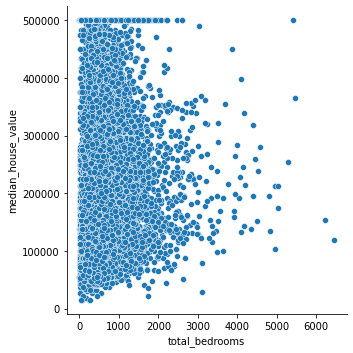

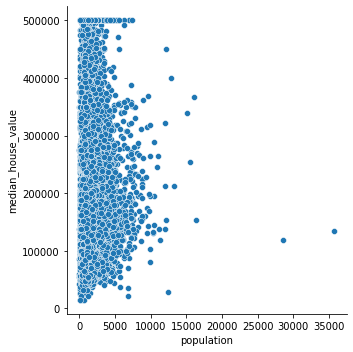

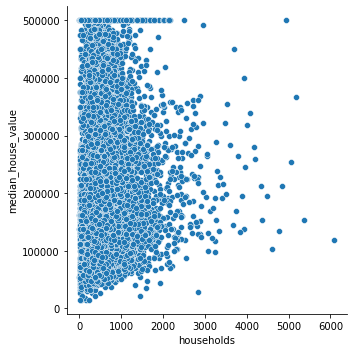

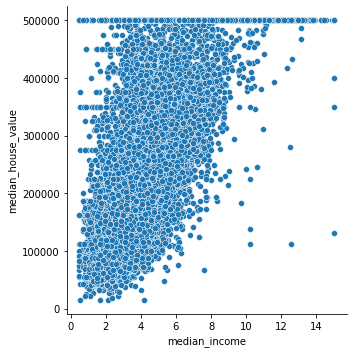

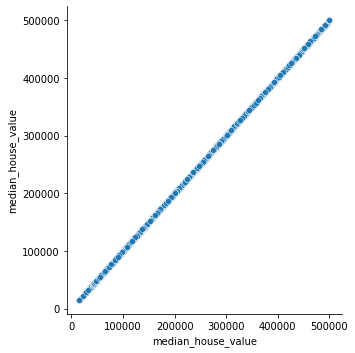

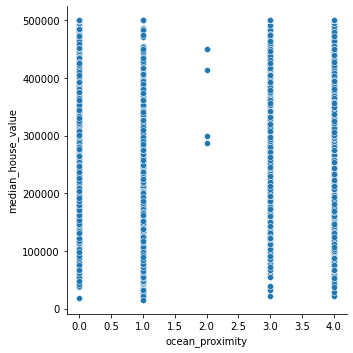

In [ ]:
import seaborn as sns

y = df['median_house_value']

for idx, col in enumerate(df.columns):
    plt.ylabel = 'median_house_value'
    plt.figure(idx, figsize=(5,5))
    sns.relplot(x=col, y=y, kind="scatter", data=df)
    plt.show

### Reports

In [ ]:
report = sv.analyze(df)

report.show_html(_folder_dir +'reports/' +_ds_report +'_full' + '.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/CS.Haifa/MSc/MLLAB/House_Price_Prediction/reports/report_full.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##Feature Engineering 

### Remove longitude	latitude features

In [ ]:
df = df.drop(labels=["longitude",	"latitude"],axis=1) # to remove columns
df.head()

In [ ]:
#drop latitude and londitude

df = df.drop(labels=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','ocean_proximity','County','Road'],axis=1) # to remove columns
df.head()

,median_income,median_house_value
0,4.2019,140100.0
1,2.2216,183900.0
2,3.1142,112600.0
3,5.2539,500001.0
4,2.8135,260300.0


### Logarithm features

In [ ]:
df['median_house_value'] = np.log2(df['median_house_value'])
df['households'] = np.log2(df['households'])
df['population'] = np.log2(df['population'])
df['total_rooms'] = np.log2(df['total_rooms'])
df['total_bedrooms'] = np.log2(df['total_bedrooms'])



### Clean up features values

In [ ]:
#clean rows
#remove rows
df.drop(df[df['total_rooms'] >= 8000].index, inplace = True)
df.drop(df[df['total_bedrooms'] > 2000].index, inplace = True)
df.drop(df[df['population'] >= 5000].index, inplace = True)
# df.drop(df[df['median_house_value'] >= 480000].index, inplace = True)




In [ ]:
df.drop(df[df['median_house_value'] <= 15.5].index, inplace = True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19926 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19926 non-null  float64
 1   latitude            19926 non-null  float64
 2   housing_median_age  19926 non-null  float64
 3   total_rooms         19926 non-null  float64
 4   total_bedrooms      19926 non-null  float64
 5   population          19926 non-null  float64
 6   households          19926 non-null  float64
 7   median_income       19926 non-null  float64
 8   median_house_value  19926 non-null  float64
 9   ocean_proximity     19926 non-null  int64  
 10  County              19926 non-null  int64  
 11  Road                19926 non-null  int64  
dtypes: float64(9), int64(3)
memory usage: 2.0 MB


In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,County,Road
0,-117.14,32.71,32.0,9.489848,7.971544,9.804131,7.700440,1.8456,16.653685,4,39,62
1,-120.72,37.38,22.0,10.356452,8.317413,10.506803,8.409391,2.2813,16.038319,1,25,131
2,-117.32,34.12,37.0,11.485829,9.164907,11.004923,9.136991,2.3508,16.105336,1,38,8508
3,-118.27,33.91,42.0,10.802516,8.483816,10.364135,8.543032,2.6250,16.625423,0,20,3935
4,-118.48,34.20,23.0,11.476746,9.754888,11.135068,9.601771,2.6957,17.548491,0,20,2853


## Training Model


### Prepare data set

In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,County,Road
0,-117.14,32.71,32.0,9.489848,7.971544,9.804131,7.700440,1.8456,4,39,62
1,-120.72,37.38,22.0,10.356452,8.317413,10.506803,8.409391,2.2813,1,25,131
2,-117.32,34.12,37.0,11.485829,9.164907,11.004923,9.136991,2.3508,1,38,8508
3,-118.27,33.91,42.0,10.802516,8.483816,10.364135,8.543032,2.6250,0,20,3935
4,-118.48,34.20,23.0,11.476746,9.754888,11.135068,9.601771,2.6957,0,20,2853


In [ ]:
#dependent feature
# if FETCH_UPDATED:
#   y = df.iloc[:,-4].values # price median_house_value with road and county
# else:
#   y = df.iloc[:,-2].values # price median_house_value with road and county

#y = df.iloc[:,-2].values # price median_house_value with road and county #use it for initial Experiment2 and Experiment 2
y = df.iloc[:,-4].values # price median_house_value with road and county #use it for Experiment 3 and 4



In [ ]:
#independent value
df.drop(labels=['median_house_value'],axis = 1,inplace=True)


In [ ]:

X = df.iloc[:,:].values

In [ ]:
from sklearn.model_selection import train_test_split

# train_test_split?
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20033 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20033 non-null  float64
 1   latitude            20033 non-null  float64
 2   housing_median_age  20033 non-null  float64
 3   total_rooms         20033 non-null  float64
 4   total_bedrooms      20033 non-null  float64
 5   population          20033 non-null  float64
 6   households          20033 non-null  float64
 7   median_income       20033 non-null  float64
 8   ocean_proximity     20033 non-null  int64  
 9   County              20033 non-null  int64  
 10  Road                20033 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 1.8 MB


### Report training set 

In [ ]:
import sweetviz as sv

compare_report = sv.compare([pd.DataFrame(data=X_train,columns=df.columns), 'Train'], [pd.DataFrame(data=X_test,columns=df.columns), 'Test'])
compare_report.show_html(_folder_dir + 'reports/'+ 'compare_Train_Test_set.html', open_browser=False)

ModuleNotFoundError: ignored

### Random Forest model

In [ ]:
#random forest
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor()

s = time.time()
random_forest_model.fit(X_train,y_train)
print("training done. time={}".format(str(datetime.timedelta(seconds=time.time() -s ))))

training done. time=0:00:10.949446


In [ ]:
#model prediction, verefication

y_pred = random_forest_model.predict(X_test)

In [ ]:
#model accuracy
from sklearn.metrics import r2_score

res=r2_score(y_test,y_pred)*100

res


84.50169198717444

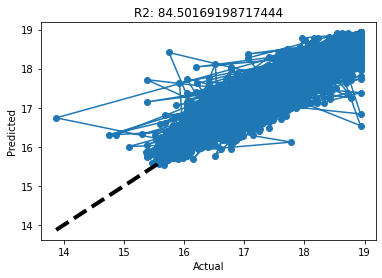

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(res))

#regression line
y_test, y_predicted = y_test.reshape(-1,1), y_pred.reshape(-1,1)
ax.plot(y_test, y_pred)

plt.show()

#### Comparing Test/Predictions reports

In [ ]:

compare_report = sv.compare([pd.DataFrame(y_test), 'True Value'], [pd.DataFrame(y_pred), 'Predicted Value'])
compare_report.show_html(_folder_dir + 'reports/' 'compare_test_with_predicted.html', open_browser=False)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

s = time.time()
linear_model.fit(X_train,y_train)
print("training done. time={}".format(str(datetime.timedelta(seconds=time.time() -s ))))


training done. time=0:00:00.027833


In [ ]:
#model prediction, verefication

y_pred = linear_model.predict(X_test)

In [ ]:
#model accuracy
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)*100

67.38925455005784

##Add our own data

In [ ]:
#452600.0
#inp = np.array([-122.23,	37.88,	41.0,	880.0	,129.0,	322.0	,126.0	,8.3252	,	3])

#186200.0
# inp = np.array([32.0	,1605.0,	314.0	,986.0,	306.0	,3.3375,		0	,1	,5387])

#232400.0
#inp = np.array([-122.41	,37.65	,32.0	,3436.0,	868.0	,2583.0,	817.0,	3.5039	,	4	,43,	6890])

#16.653685
inp = np.array([-117.14	,32.71,	32.0,	9.489848,	7.971544,	9.804131,	7.700440,	1.8456,		4,	39,	62])


inp

array([-117.14    ,   32.71    ,   32.      ,    9.489848,    7.971544,
          9.804131,    7.70044 ,    1.8456  ,    4.      ,   39.      ,
         62.      ])

In [ ]:
ip = inp.reshape((1,-1))
ip

array([[-117.14    ,   32.71    ,   32.      ,    9.489848,    7.971544,
           9.804131,    7.70044 ,    1.8456  ,    4.      ,   39.      ,
          62.      ]])

In [ ]:
random_forest_model.predict(ip)

array([16.43622902])

88674.33712215674

In [ ]:
linear_model.predict(ip)

array([16.79347369])

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('House_Price_Prediction.ipynb')

--2021-12-27 12:47:39--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2021-12-27 12:47:39 (28.8 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/House_Price_Prediction.ipynb to pdf
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed (u'errorDetails' was unexpected)

Failed validating u'additionalProperties' in error:

On instance[u'cells'][77][u'outputs'][0]:
{u'ename': u'ModuleNotFoundError',
 u'errorDetails': {

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'